# Final Project - Reinforcements Learning 
Hello dear students,<br> this is the template notebook. Please click on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Aviv Slobodkin 307847962
<br>
Student 2: Shir Ashury Tahan 203284849
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import schedules
from scipy.special import softmax
import torch.nn.functional as F
from collections import deque
import pdb

TILE_SIZE=16
IS_TINY_RGB=False
ONLY_PERMITTED_ACTIONS = True



# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox mapping: {env.box_mapping}')

In [ ]:
def run_video(trained_sokoban, MAX_STEPS_IN_EPISODE=500):
  iter = 0
  env = trained_sokoban.get_env()
  policy = trained_sokoban.get_policy()
  state_size = trained_sokoban.state_size

  if trained_sokoban.get_isFixed():
    random.seed(2)
  else:
    random.seed()
  state = env.reset()

  total_rewards = 0
  done = False
  video_filename = 'imageio.mp4'
  with imageio.get_writer(video_filename, fps=3) as video:
      video.append_data(env.render(mode='rgb_array'))
      while (iter < MAX_STEPS_IN_EPISODE):
        if done:
          break
        if IS_TINY_RGB:
          state = env.render(mode='tiny_rgb_array')
        state = preprocess_state(state, state_size)
        state = state.reshape(1,state_size[0],state_size[1],3)        
        act_values = policy.actor.predict(state, verbose=0)
        # print(act_values)

        curr_allowed_actions = allowed_actions(env)
        if ONLY_PERMITTED_ACTIONS:
          act_values[0] = [-np.inf if not i in curr_allowed_actions else elem for i,elem in enumerate(act_values[0])]
        action = np.argmax(act_values[0])

        print_env_det(env)


        new_state, reward, done, _ = env.step(action)

        print(f"action taken: {action} ({action_translation(action)})")

        total_rewards += reward
        state = new_state
        video.append_data(env.render(mode='rgb_array'))
        iter = iter + 1

  print("steps: " + str(iter))
  return embed_mp4(video_filename)

# General Util Functions

In [ ]:
def action_translation(action_i):
  action_dict = {0:"Push Right", 
                 1:"Push Up", 2:"Push Down", 3:"Push Left", 4:"Push Right",
                 5:"Move Up", 6:"Move Down", 7:"Move Left", 8:"Move Right",
                 9:"Pull Up", 10:"Pull Down", 11:"Pull Left", 12:"Pull Right"}
  return action_dict[action_i]

In [ ]:
def preprocess_state(state, state_size):
  img = Image.fromarray(state)
  #crop frame - it's constant during all the games
  left = 1 if IS_TINY_RGB else TILE_SIZE
  top = 1 if IS_TINY_RGB else TILE_SIZE
  right = state.shape[0] - TILE_SIZE
  bottom = state.shape[0] - TILE_SIZE
  new_img = img.crop((left,top,right,bottom))
  #resize to smaller image
  resized_img = new_img.resize((state_size[0],state_size[1]))
  # resized_img = new_img.resize((5,5)) if IS_TINY_RGB else new_img.resize((32,32))
  return np.array(resized_img)

In [ ]:
def allowed_actions(env):
  allowed_actions = ["Push Up", "Push Down", "Push Left", "Push Right",
                     "Move Up", "Move Down", "Move Left", "Move Right",
                     "Pull Up", "Pull Down", "Pull Left", "Pull Right"]

  pl_y,pl_x = env.player_position
  box_y, box_x = list(env.box_mapping.values())[0]
  room_state = env.room_state # indicates locations of walls (0), and non-walls (o.w.)
  
  # stands by the walls
  if pl_y == 6 or room_state[pl_y+1,pl_x] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Down")]
  if pl_y == 0 or room_state[pl_y-1,pl_x] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Up")]
  if pl_x == 6 or room_state[pl_y,pl_x+1] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Right")]
  if pl_x == 0 or room_state[pl_y,pl_x-1] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Left")]
  
  # box is by the frame walls and player adjacent
  if pl_x == box_x and box_y == pl_y+1 and room_state[box_y+1,box_x] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Down")]
  if pl_x == box_x and box_y == pl_y-1 and room_state[box_y-1,box_x] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Up")]
  if pl_y == box_y and box_x == pl_x+1 and room_state[box_y,box_x+1] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Right")]
  if pl_y == box_y and box_x == pl_x-1 and room_state[box_y,box_x-1] == 0:
    allowed_actions = [a for a in allowed_actions if not a.endswith("Left")]

  
  # can only push if box in front
  if pl_x == box_x and box_y == pl_y+1:
    allowed_actions = [a for a in allowed_actions if not a in ["Move Down", "Pull Down"]]
  if pl_x == box_x and box_y == pl_y-1:
    allowed_actions = [a for a in allowed_actions if not a in ["Move Up", "Pull Up"]]
  if pl_y == box_y and box_x == pl_x+1:
    allowed_actions = [a for a in allowed_actions if not a in ["Move Right", "Pull Right"]]
  if pl_y == box_y and box_x == pl_x-1:
    allowed_actions = [a for a in allowed_actions if not a in ["Move Left", "Pull Left"]]

  # if stuck (no actions are allowed)
  if len(allowed_actions) == 0:
    return list(range(13))
    
  return [action_i for action_i in range(13) if action_translation(action_i) in allowed_actions]

In [ ]:
a = [10, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
[a.remove(elem) for elem in a if elem in [0,1,2]]
a

[10, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]

# Actor-Critic

### Actor-Critic class

In [ ]:
class A2C():
    def __init__(self, state_size, action_size, 
                 critic_lr=0.01, actor_lr=0.01, gamma=0.99, 
                 epsilon=0.99, epsilon_min=0.1, epsilon_decay=0.98,
                 weight_backup_critic="sokoban_weight_critic.h5",
                 weight_backup_actor="sokoban_weight_actor.h5"):
      
        self.weight_backup_critic      = weight_backup_critic
        self.weight_backup_actor       = weight_backup_actor
        self.state_size                = state_size
        self.action_size               = action_size
        self.memory                    = deque(maxlen=2000)
        self.critic_lr                 = critic_lr 
        self.gamma                     = gamma 
        self.epsilon                   = epsilon
        self.epsilon_min               = epsilon_min
        self.epsilon_decay             = epsilon_decay 
        self.actor_lr                  = actor_lr
        self.actor_lr_schedule         = schedules.ExponentialDecay(
                                          initial_learning_rate=self.actor_lr,
                                          decay_steps=10000,
                                          decay_rate=0.9)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=self.actor_lr_schedule)

        self.critic = self._build_critic()
        self.actor  = self._build_actor()

        print("critic model:")
        print(self.critic.summary()) 
        print("#########################################################")
        print("actor model:")
        print(self.actor.summary()) 

    def _build_critic(self):
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=self.state_size))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        lr_schedule = schedules.ExponentialDecay(
                                  initial_learning_rate=self.critic_lr,
                                  decay_steps=10000,
                                  decay_rate=0.9)
        model.compile(loss='mse', optimizer=Adam(learning_rate=lr_schedule))

        # model.compile(loss='mse', optimizer=Adam(learning_rate=self.critic_lr))

        if os.path.isfile(self.weight_backup_critic):
            print("Found saved critic weights. Loading model")
            model.load_weights(self.weight_backup_critic)
            self.epsilon = self.epsilon_min
        return model

    def _build_actor(self): 
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=self.state_size))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))

        if os.path.isfile(self.weight_backup_actor):
            print("Found saved actor weights. Loading model")
            model.load_weights(self.weight_backup_actor)
            self.epsilon = self.epsilon_min
        return model

    def save_model(self):
            self.critic.save(self.weight_backup_critic)
            self.actor.save(self.weight_backup_actor)

    def act(self, state, curr_env=None):
        if curr_env != None:
          curr_allowed_actions = allowed_actions(curr_env)
        else:
          curr_allowed_actions = list(range(self.action_size))

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = state.reshape(1,self.state_size[0],self.state_size[1],3)
        act_values = self.actor.predict(state, verbose=0)
        if ONLY_PERMITTED_ACTIONS:
          act_values[0] = [-np.inf if not i in curr_allowed_actions else elem for i,elem in enumerate(act_values[0])]
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))


    def fit_critic(self, sample_batch):
      targets = []
      for state, action, reward, next_state, done in sample_batch:
          target = reward
          if not done:
            next_state = next_state.reshape(1,self.state_size[0],self.state_size[1],3)
            action_prime = self.act(next_state)
            target = reward + self.gamma * self.critic.predict(next_state, verbose=0)[0][action_prime]
            targets.append(target)
          state = state.reshape(1,self.state_size[0],self.state_size[1],3)
          target_f = self.critic.predict(state, verbose=0)
          target_f[0][action] = target
          self.critic.fit(state, target_f, epochs=1, verbose=0)
      return targets

    def fit_actor(self, sample_batch, targets):

      batch_states = tf.stack([tpl[0] for tpl in sample_batch])
      batch_actions_real = tf.convert_to_tensor([self.act(tpl[0]) for tpl in sample_batch])

    
      batch_actions_real = tf.one_hot(batch_actions_real, depth=self.action_size)

      critic_values = [np.mean(self.critic.predict(tpl[0].reshape(1,self.state_size[0],self.state_size[1],3), verbose=0)[0]) for tpl in sample_batch]

      # need to convert to float32 due to tf compatability
      critic_values = np.array(critic_values).astype('float32')
      targets = np.array(targets).astype('float32')

      advantages = tf.convert_to_tensor(targets) -  tf.convert_to_tensor(critic_values)

      with tf.GradientTape() as tape:
        action_probs = self.actor(batch_states, training=True) # Forward pass

        # to avoid log-probabilities that are -inf (i.e., prob=0)
        action_probs = tf.clip_by_value(action_probs, 1e-20, 1.0)

        neg_log_probs = tf.reduce_sum(-tf.math.log(action_probs) * batch_actions_real, axis=1)
        actor_loss = tf.reduce_mean(neg_log_probs * advantages)
      actor_gradients = tape.gradient(actor_loss, self.actor.trainable_variables)
      self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor.trainable_variables))

      return actor_loss


    def replay(self, sample_batch_size, isNewEpisode):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        
        # fit Critic
        targets = self.fit_critic(sample_batch)
        
        # fit Actor
        loss = self.fit_actor(sample_batch, targets)
        if isNewEpisode:
          print(f"Actor loss:{loss}")


        if self.epsilon > self.epsilon_min and isNewEpisode:
            self.epsilon *= self.epsilon_decay

### Sokoban class

#### SokobanEpisode

In [ ]:
class SokobanEpsiode:
    def __init__(self, isFixed=True, max_steps=500, sample_batch_size=32, 
                  episodes = 100, save_every=10,
                  critic_lr=0.01, actor_lr=0.01, gamma=0.99, 
                  epsilon=0.99, epsilon_min=0.1, epsilon_decay=0.999):
        """
        performs updates after a full episode
        """
        self.sample_batch_size = sample_batch_size 
        self.episodes =  episodes
        self.isFixed = isFixed
        self.env = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1, max_steps=max_steps)
        
        if self.isFixed:
          random.seed(2)
          _ = self.env.reset()
        print_env_det(self.env)
        
        self.state_size        = (64,64,3) #self.env.observation_space.shape
        self.action_size       = self.env.action_space.n
        self.a2c = A2C(state_size = self.state_size, action_size = self.action_size,
                        critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, 
                         epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                         weight_backup_critic=f"SokobanEpsiode_weight_state_size_{self.state_size[0]}_critic.h5",
                         weight_backup_actor=f"SokobanEpsiode_weight_state_size_{self.state_size[0]}_actor.h5")
        self.rewards        = []
        self.steps        = []
        self.save_every = save_every

    def get_rewards(self):
      return self.rewards

    def get_steps(self):
      return self.steps

    def get_env(self):
      return self.env
    
    def get_policy(self):
      return self.a2c 
    
    def get_isFixed(self):
      return self.isFixed


    def run(self):
        try:
            for index_episode in range(self.episodes):
                total_reward = 0
                if self.isFixed:
                  random.seed(2)
                else:
                  random.seed()
                state = self.env.reset()
                if IS_TINY_RGB:
                  state = self.env.render(mode='tiny_rgb_array')
                state = preprocess_state(state, self.state_size)
                done = False
                index = 0
                while not done:
                    # self.env.render()
                    action = self.a2c.act(state)
                    next_state, reward, done, _ = self.env.step(action)
                    
                    if IS_TINY_RGB:
                      next_state = self.env.render(mode='tiny_rgb_array')
                    next_state = preprocess_state(next_state, self.state_size)
                    total_reward += reward
                    # print(f"took step: {action_translation(action)}")
                    self.a2c.remember(state, action, reward, next_state, done)
                    state = next_state
                    index += 1
                print(f"Episode {index_episode}, Steps: {index}")
                self.a2c.replay(self.sample_batch_size, True)
                self.steps.append(index)
                self.rewards.append(float("{:.5f}".format(total_reward)))
                if index_episode % self.save_every == 0:
                  self.a2c.save_model()
                  print(f'Average reward so far: {np.mean(self.rewards)}')
                  print(f'Best reward so far: {np.max(self.rewards)}')

        finally:
            self.a2c.save_model()

#### SokobanStep

In [ ]:
class SokobanStep:
    def __init__(self, isFixed=True, max_steps=500, sample_batch_size=32, 
                  episodes = 100, save_every=10,
                  critic_lr=0.01, actor_lr=0.01, gamma=0.99, 
                  epsilon=0.99, epsilon_min=0.1, epsilon_decay=0.999):
        """
        performs updates after every step
        """
        self.sample_batch_size = sample_batch_size 
        self.episodes =  episodes
        self.isFixed = isFixed
        self.env = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1, max_steps=max_steps)
        self.replay_step_frequecny = 10

        if self.isFixed:
          random.seed(2)
          _ = self.env.reset()
        print_env_det(self.env)
        
        self.state_size        = (32,32,3) #self.env.observation_space.shape
        self.action_size       = self.env.action_space.n
        self.a2c = A2C(self.state_size, self.action_size,
                        critic_lr=critic_lr, actor_lr=actor_lr, gamma=gamma, 
                         epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                         weight_backup_critic=f"SokobanStep_weight_state_size_{self.state_size[0]}_critic.h5",
                         weight_backup_actor=f"SokobanStep_weight_state_size_{self.state_size[0]}_actor.h5")
        self.rewards        = []
        self.steps        = []
        self.save_every = save_every

    def get_rewards(self):
      return self.rewards

    def get_steps(self):
      return self.steps

    def get_env(self):
      return self.env
    
    def get_policy(self):
      return self.a2c 
    
    def get_isFixed(self):
      return self.isFixed


    def run(self):
        try:
            for index_episode in range(self.episodes):
                total_reward = 0
                if self.isFixed:
                  random.seed(2)
                else:
                  random.seed()
                state = self.env.reset()
                if IS_TINY_RGB:
                  state = self.env.render(mode='tiny_rgb_array')
                state = preprocess_state(state, self.state_size)
                done = False
                index = 0
                while not done:
                  isNewEpisode = index == 0
                  # self.env.render()
                  action = self.a2c.act(state)
                  next_state, reward, done, _ = self.env.step(action)
                  
                  if IS_TINY_RGB:
                    next_state = self.env.render(mode='tiny_rgb_array')
                  next_state = preprocess_state(next_state, self.state_size)
                  total_reward += reward
                  # print(f"took step: {action_translation(action)}")
                  self.a2c.remember(state, action, reward, next_state, done)
                  state = next_state
                  index += 1
                  if index % self.replay_step_frequecny == 0:
                    self.a2c.replay(self.sample_batch_size, isNewEpisode)

                self.steps.append(index)
                self.rewards.append(float("{:.5f}".format(total_reward)))
                print(f"Episode {index_episode}, Steps: {index}")
                if index_episode % self.save_every == 0:
                  self.a2c.save_model()
                  print(f'Average reward so far: {np.mean(self.rewards)}')
                  print(f'Best reward so far: {np.max(self.rewards)}')

        finally:
            self.a2c.save_model()

### run train

In [ ]:
sokoban = SokobanEpsiode()
sokoban.run()

In [ ]:
run_video(trained_sokoban=sokoban, MAX_STEPS_IN_EPISODE=500)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[2 4]
Box mapping: {(4, 2): (3, 4)}
action taken: 8 (Move Right)
Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[2 5]
Box mapping: {(4, 2): (3, 4)}
action taken: 1 (Push Up)
Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 5]
Box mapping: {(4, 2): (3, 4)}
action taken: 2 (Push Down)
Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[2 5]
Box mapping: {(4, 2): (3, 4)}
action taken: 1 (Push Up)
Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 5]
Box mapping: {(4, 2): (3, 4)}
action taken: 2 (Push Down)
Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[2 5]
Box mapping: {(4, 2): (3, 4)}
action taken: 1 (Push Up)
Observati

In [ ]:
sokoban = SokobanStep()
sokoban.run()

In [ ]:
run_video(trained_sokoban=sokoban, MAX_STEPS_IN_EPISODE=500)

# Feeling the Env

### EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
np.random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1)
# state = sok.reset()
np.random.seed(2)
# state
# pdb.set_trace()
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[4 2]
Box mapping: {(3, 5): (4, 2)}


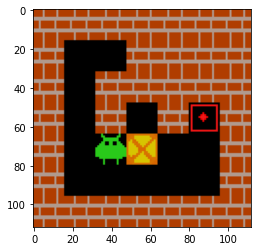

In [ ]:
#=============== DO NOT DELETE ===============
# random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1)
random.seed(2)
state = sok.reset()
# random.seed(2)

# np.random.seed(2)
# state
# pdb.set_trace()
# ============================================
observation, reward, done, _ = sok.step(0)
creen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
print_env_det(sok)

In [ ]:
sok.render(mode='tiny_rgb_array').shape

(7, 7, 3)

### EX1 - Video test

In [ ]:
env = sok
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


## EX2 - PUSH & PULL - ONE BOX

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[3 3]
Box mapping: {(3, 5): (3, 4)}


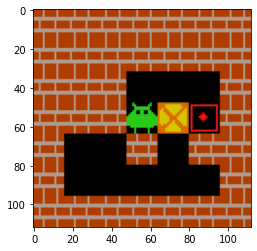

In [ ]:
screen = sok_2.render(mode='rgb_array')
plt.imshow(sok_2.render('rgb_array'))
# observation, reward, done, _ = sok_2.step(1)
print_env_det(sok_2)

### EX2 - Video test

In [ ]:
env = sok_2
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

## EX3 - PUSH & PULL - TWO BOXES

In [ ]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 5]
Box mapping: {(1, 2): (1, 4), (2, 3): (2, 4)}


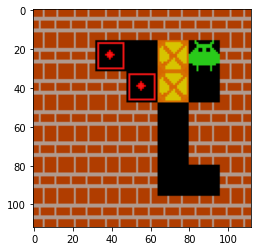

In [ ]:
screen = sok_3.render(mode='rgb_array')
plt.imshow(sok_3.render('rgb_array'))
print_env_det(sok_3)

### EX3 - Video test

In [ ]:
env = sok_3
start_time = time.time()
done = False
iter = 0
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while (iter < 10) or not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 3:
      break
    iter +=1
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)